In [ ]:
from Datapreparation import *
import warnings
warnings.filterwarnings("ignore")
from models import *
from satellite_eda import *
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Initialize Irregular Satellites and Hyperparameters

In [2]:
satellites_dict = {
    "jason3": ("./orbital_elements/Jason-3.csv", "./manoeuvres/ja3man.txt"),
    "SRL": ("./orbital_elements/SARAL.csv", "./manoeuvres/srlman.txt"), 
    "TOP": ("./orbital_elements/TOPEX.csv", "./manoeuvres/topman.txt")
}

satellites = []
for _, path in satellites_dict.items():
    sate = Satellite(path[0], path[1])
    satellites.append(sate)
    
arima_grid = {'p': [0,1,2], 'q': [0,1,2], 'd': [0,1]}

xgb_grid   = {
    'n_lags':     [90, 180, 360],
    'n_estimators':[10, 20],
    'max_depth':  [5, 10],
    'colsample_bytree': [0.5, 0.7],
    'learning_rate': [0.01, 0.05, 0.1]
}

buffers = [1,2,3]  # days

print(len(satellites))
print(satellites)

Loading dataset JASO3 Ready.
Loading dataset SARAL Ready.
Loading dataset TOPEX Ready.
3
[<Datapreparation.Satellite object at 0x000002A1ED745C90>, <Datapreparation.Satellite object at 0x000002A1ED649AD0>, <Datapreparation.Satellite object at 0x000002A1ED753B90>]


# Lag-Only vs. Multivariate XGBoost Models (SARAL Example)
Because irregular satellites exhibit more complex Brouwer Mean Motion patterns, we extend our approach to a multivariate XGBoost model to evaluate whether incorporating additional orbital features improves detection performance. 

In [ ]:
# XGBoost grid search
def xgb_optimized_search(satellite, xgb_grid, brouwer_only, buffer=3):
    xgb = XGBoostModel(satellite, brouwer_only) # multivariate
    xgb.grid_search(xgb_grid, buffer)
    print("XGB best params:", xgb.best_params, "pr_auc:", xgb.eval_results['pr_auc'])
    return xgb

# plot XGB results
def plot_xgb_only(model, buffers, brouwer_only):
    plt.figure(figsize=(4, 3))
    for buffer in buffers:
        model.evaluate(buffer)
        eval_res2 = model.eval_results  
        plt.plot(eval_res2['recalls'], eval_res2['precisions'], label=f"{model.name} (buffer={buffer})")
    if brouwer_only:
        plt.title(f"Univariate XGB")
    else:
        plt.title(f"Multivariate XGB")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Loading dataset SARAL Ready.
--------------------------------------------Univariate XGBoost for SARAL----------------------------
XGB best params: {'n_lags': 90, 'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5} pr_auc: 0.35717213204658793


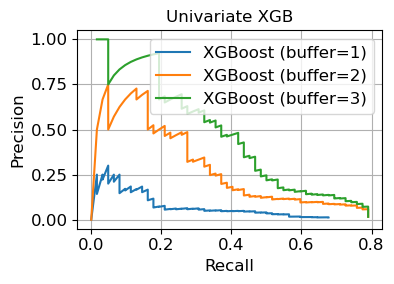

--------------------------------------------Multivariate XGBoost for SARAL--------------------------
XGB best params: {'n_lags': 90, 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5} pr_auc: 0.08393667418073754


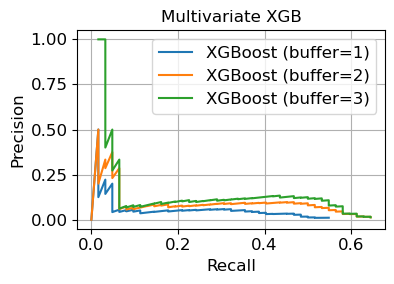

In [ ]:
sate = Satellite("./orbital_elements/SARAL.csv", "./manoeuvres/srlman.txt") # SARAL example
# Run univariate XGBoost
print(f"--------------------------------------------Univariate XGBoost for {sate.name}----------------------------")
brouwer_only = True
uni_xgb = xgb_optimized_search(sate, xgb_grid, brouwer_only)
plot_xgb_only(uni_xgb, buffers, brouwer_only)

# Run multivariate XGBoost
print(f"--------------------------------------------Multivariate XGBoost for {sate.name}--------------------------")
brouwer_only = False
multi_xgb = xgb_optimized_search(sate, xgb_grid, brouwer_only)
plot_xgb_only(multi_xgb, buffers, brouwer_only)


# Evaluation on Irregular Satellites Using Univariate XGBoost and ARIMA

In [ ]:
# Baseline model-no differencing
xgb_grid   = {
    'n_lags':     [90, 180, 360],
    'n_estimators':[10, 20],
    'max_depth':  [5, 10],
    'colsample_bytree': [0.5, 0.7],
    'learning_rate': [0.01, 0.05, 0.1],
    'diff_order':[0]
}


def optimized_search(satellite, arima_grid, xgb_grid, buffer=3):
    arima = ARIMAModel(satellite)
    arima.grid_search(arima_grid, buffer)
    print("ARIMA best params:", arima.best_params, "pr_auc:", arima.eval_results['pr_auc'])

    xgb = XGBoostModel(satellite, brouwer_only=True) 
    xgb.grid_search(xgb_grid, buffer)
    print("XGB best params:", xgb.best_params, "pr_auc:", xgb.eval_results['pr_auc'])
    return arima, xgb

def plot(satellite, buffers):
    plt.figure(figsize=(8, 6))
    arima = satellite.arima
    xgb = satellite.xgb
    for buffer in buffers:
        arima.evaluate(buffer)
        eval_res = arima.eval_results  
        plt.plot(eval_res['recalls'], eval_res['precisions'], label=f"{arima.name} (buffer={buffer})")

        xgb.evaluate(buffer)
        eval_res2 = xgb.eval_results  
        plt.plot(eval_res2['recalls'], eval_res2['precisions'], label=f"{xgb.name} (buffer={buffer})")

    plt.title(f"Precision–Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Loading dataset JASO3 Ready.
--------------------------------------------JASO3---------------------------------------------------
ARIMA best params: {'p': 0, 'q': 2, 'd': 0} pr_auc: 0.5347913858179404
XGB best params: {'n_lags': 180, 'n_estimators': 20, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5} pr_auc: 0.25241210065904385


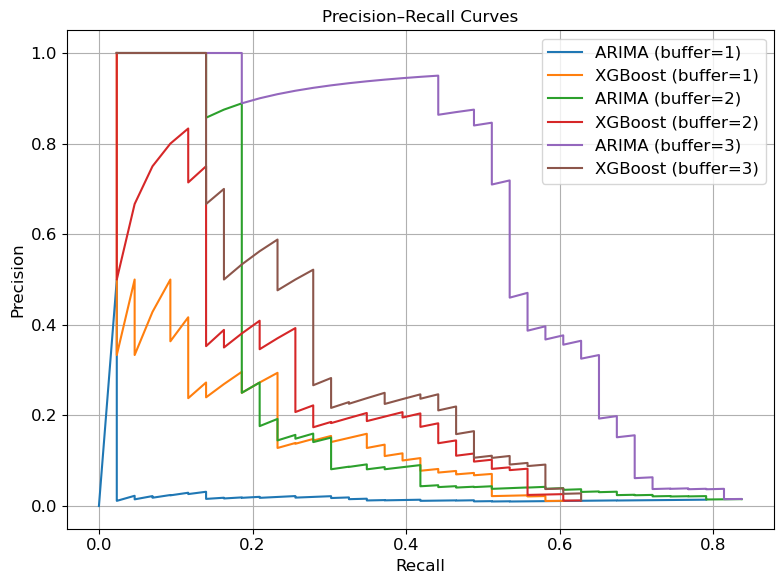

-----------------------------------------------------------------------------------------------------------



Loading dataset SARAL Ready.
--------------------------------------------SARAL---------------------------------------------------
ARIMA best params: {'p': 0, 'q': 2, 'd': 0} pr_auc: 0.34496257739714925
XGB best params: {'n_lags': 90, 'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5} pr_auc: 0.35717213204658793


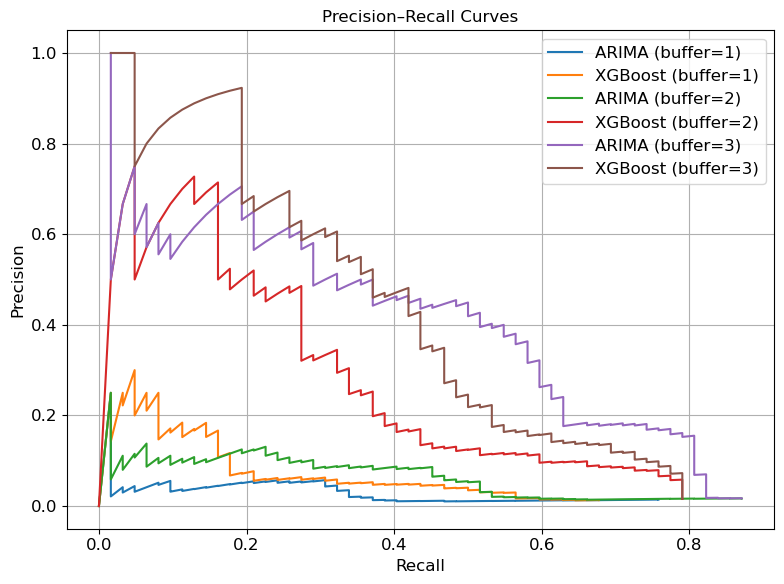

-----------------------------------------------------------------------------------------------------------



Loading dataset TOPEX Ready.
--------------------------------------------TOPEX---------------------------------------------------
ARIMA best params: {'p': 1, 'q': 2, 'd': 0} pr_auc: 0.20275915468864447
XGB best params: {'n_lags': 90, 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5} pr_auc: 0.0856727537610605


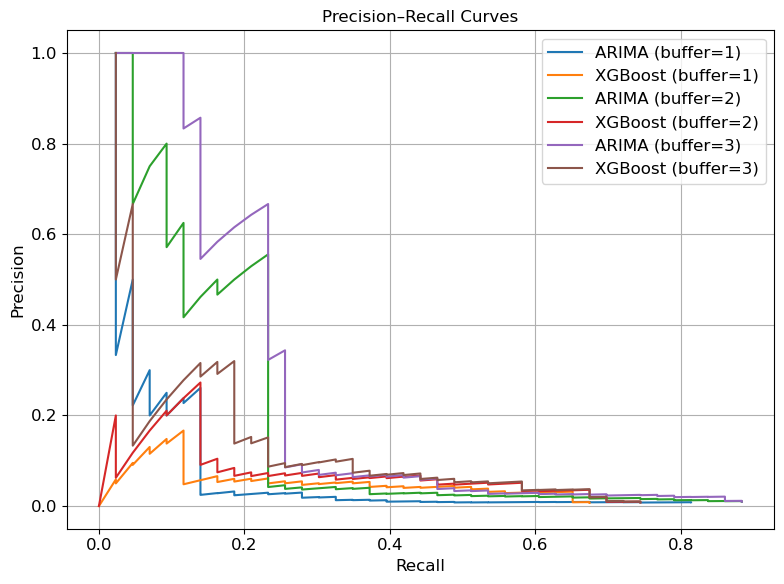

-----------------------------------------------------------------------------------------------------------





In [ ]:
# Baseline without differencing
for sate in satellites:
    print(f"--------------------------------------------{sate.name}---------------------------------------------------")
    optimized_search(sate, arima_grid, xgb_grid)
    plot(sate, buffers)
    print("-----------------------------------------------------------------------------------------------------------")
    print()
    print()
    print()

--------------------------------------------JASO3---------------------------------------------------
ARIMA best params: {'p': 0, 'q': 2, 'd': 0} pr_auc: 0.5347913858179404
XGB best params: {'n_lags': 90, 'n_estimators': 20, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'diff_order': 2} pr_auc: 0.623651476589384


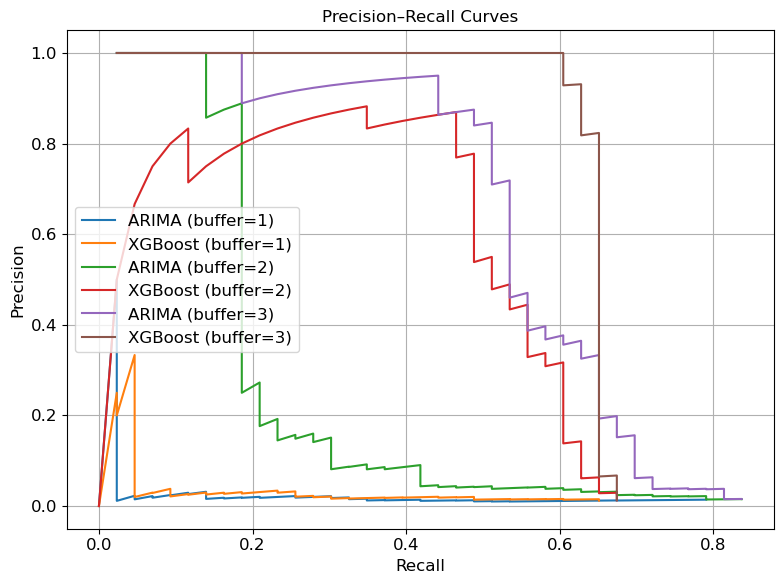

-----------------------------------------------------------------------------------------------------------



--------------------------------------------SARAL---------------------------------------------------
ARIMA best params: {'p': 0, 'q': 2, 'd': 0} pr_auc: 0.34496257739714925
XGB best params: {'n_lags': 90, 'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'diff_order': 1} pr_auc: 0.6795061914044446


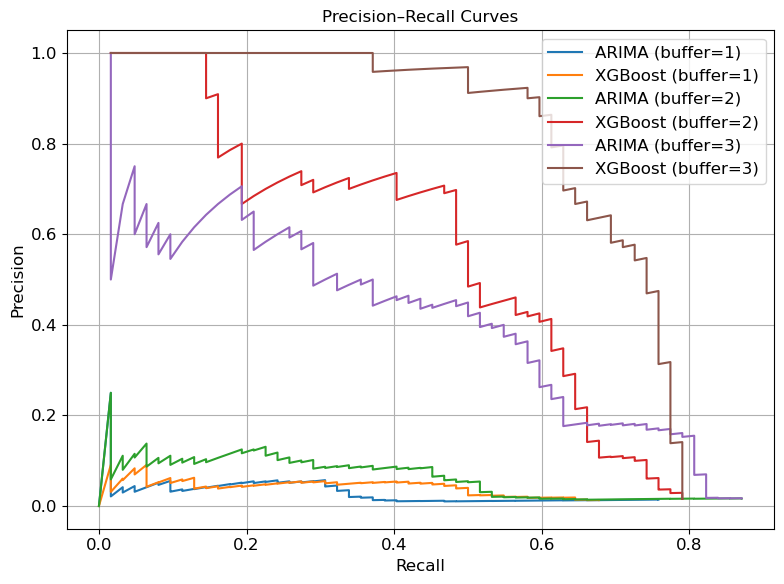

-----------------------------------------------------------------------------------------------------------



--------------------------------------------TOPEX---------------------------------------------------
ARIMA best params: {'p': 1, 'q': 2, 'd': 0} pr_auc: 0.20275915468864447
XGB best params: {'n_lags': 180, 'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'diff_order': 2} pr_auc: 0.22613483104692989


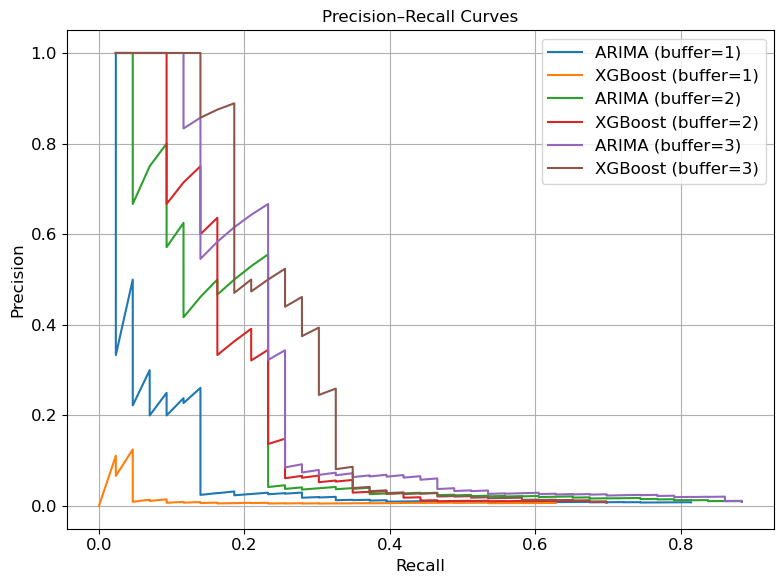

-----------------------------------------------------------------------------------------------------------





In [5]:
xgb_grid   = {
    'n_lags':     [90, 180],
    'n_estimators':[20,30],
    'max_depth':  [5, 10],
    'colsample_bytree': [0.5, 0.7],
    'learning_rate': [0.05, 0.1, 0.3],
    'diff_order':[1,2]
}

for sate in satellites:
    print(f"--------------------------------------------{sate.name}---------------------------------------------------")
    optimized_search(sate, arima_grid, xgb_grid)
    plot(sate, buffers)
    print("-----------------------------------------------------------------------------------------------------------")
    print()
    print()
    print()